In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models

import matplotlib.pyplot as plt

/Users/treycole/Codes/WanPy/top_obstruction


In [2]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [3]:
### Trial wavefunctions
omit_sites = 6
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) 
# tf_list = list(low_E_sites)

n_tfs = len(tf_list)
Wan_frac = n_tfs/n_occ

save_sfx = model_str + f'_tfx={np.array(tf_list, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.4_tfx=[0 2 4]


In [4]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
    
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

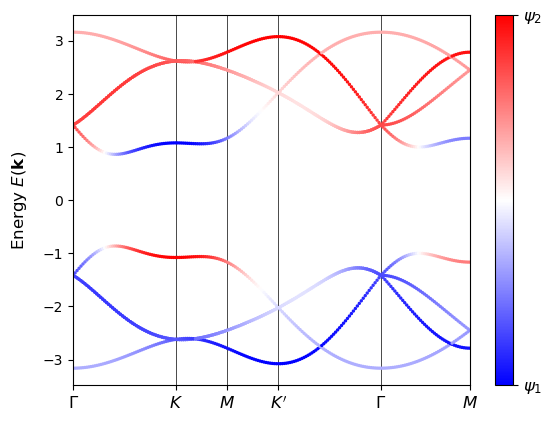

In [5]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

model.plot_bands(
    k_path, k_label=k_label, nk=201, scat_size=2, red_lat_idx=high_E_sites
    )

In [25]:
u_energy = WF.energy_eigstates.get_states()["Cell periodic"]  # energy eigenstates
u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
u_tilde = WF.tilde_states.get_states()["Cell periodic"]  # reduced tilde states

## Projectors on full mesh
P, Q = WF.energy_eigstates.get_projector(return_Q=True)  # full band projector
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj())  # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ[..., :, :]  # occ complement
P_tilde, Q_tilde = WF.tilde_states.get_projector(return_Q=True)  # tilde space projectors
P_diff = P_occ - P_tilde  # complementary subspace

eigvals, eigvecs = np.linalg.eigh(P_diff)  # states spanning complement
u_comp = eigvecs[..., :, -1]  # take state with non-zero eigval
u_comp = u_comp[..., np.newaxis, :]  # single state

k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk_til = WF.interp_energies(k_vec, ret_eigvecs=True)

# Complementary subspace interpolated energies and states
interp_energies_comp, interp_unk_comp = WF.interp_energies(
    k_vec, u_tilde=u_comp, ret_eigvecs=True) 
interp_unk_til.conj().shape

(101, 3, 8)

In [52]:
def get_Omega_I_k(P, Q_nbr, k_mesh):
    nks = P.shape[:2]
    Nk = np.prod(nks)
    num_nnbrs = Q_nbr.shape[2]
    w_b, _, idx_shell = k_mesh.get_weights(N_sh=1)

    T_kb = np.zeros((*nks, num_nnbrs), dtype=complex)
    for idx, idx_vec in enumerate(idx_shell[0]):  # nearest neighbors
        T_kb[..., idx] = np.trace(P[..., :, :] @ Q_nbr[..., idx, :, :], axis1=-1, axis2=-2)

    return (1 / Nk) * w_b[0] * np.sum(T_kb, axis=-1)

def get_Omega_I(P, Q_nbr, k_mesh):
    nks = P.shape[:2]
    Nk = np.prod(nks)
    num_nnbrs = Q_nbr.shape[2]
    w_b, _, idx_shell = k_mesh.get_weights(N_sh=1)

    T_kb = np.zeros((*nks, num_nnbrs), dtype=complex)
    for idx, idx_vec in enumerate(idx_shell[0]):  # nearest neighbors
        T_kb[..., idx] = np.trace(P[..., :, :] @ Q_nbr[..., idx, :, :], axis1=-1, axis2=-2)

    return (1 / Nk) * w_b[0] * np.sum(T_kb)


def get_Omega_til(M, w_b, k_shell):
        nks = M.shape[:-3]
        Nk = np.prod(nks)
        k_axes = tuple([i for i in range(len(nks))])

        diag_M = np.diagonal(M, axis1=-1, axis2=-2)
        log_diag_M_imag = np.log(diag_M).imag
        abs_diag_M_sq = abs(diag_M) ** 2

        r_n = -(1 / Nk) * w_b * np.sum(log_diag_M_imag, axis=k_axes).T @ k_shell

        Omega_tilde = (1 / Nk) * w_b * ( 
                np.sum((-log_diag_M_imag - k_shell @ r_n.T)**2) + 
                np.sum(abs(M)**2) - np.sum(abs_diag_M_sq)
            )
        return Omega_tilde

In [83]:
from itertools import product
nks = 4,
supercell = list(product(*[range(-int((nk-nk%2)/2), int((nk-nk%2)/2)+1) for nk in nks]))  # used for real space looping of WFs
supercell 

[(-2,), (-1,), (0,), (1,), (2,)]

In [ ]:
# Fourier transform to real space
Nk = 5
H_R = np.zeros((len(supercell), Nk), dtype=complex)
for idx, (x, y) in enumerate(self.supercell):
    for k_idx in H_k.shape[0]:
        R_vec = np.array([x, y])
        phase = np.exp(-1j * 2 * np.pi * np.vdot(k_mesh[k_idx], R_vec))
        H_R[idx, :, :] += H_k[k_idx] * phase / Nk
        u_R[idx] += u_tilde[k_idx] * phase / Nk

In [50]:
k_mesh = K_mesh(model, 20, 20)
wb, k_shell, idx_shell = k_mesh.get_weights(N_sh=1)
wb = wb[0]
k_shell = k_shell[0]

In [57]:
Bloch_comp = Bloch(model, 20, 20)
Bloch_comp.set_wfs(u_comp, cell_periodic=True)
P_comp, Q_comp = Bloch_comp.get_projector(return_Q=True)
P_nbr_comp, Q_nbr_comp = Bloch_comp.get_nbr_projector(return_Q=True)
M_comp = Bloch_comp._M

M_til = WF.tilde_states._M
omega_i_k_comp = get_Omega_I_k(P_comp, Q_nbr_comp, k_mesh)
omega_i_k_comp = omega_i_k_comp[..., np.newaxis]
omega_i_comp = get_Omega_I(P_comp, Q_nbr_comp, k_mesh)
omega_til_comp = get_Omega_til(M_comp, wb, k_shell)

omega_I_til_k = WF.get_Omega_I_k(tilde=True)
omega_I_til_k = omega_I_til_k[..., np.newaxis]
omega_I_til = WF.get_Omega_I(tilde=True)
omega_til_til = get_Omega_til(M_til, wb, k_shell)

In [58]:
print(omega_I_til)
print(omega_til_til)
print(omega_i_comp)
print(omega_til_comp)

(0.6577988768566037-7.652610051162235e-18j)
0.04676056885263972
(0.6496740788925466+1.9666370205050336e-17j)
7.092618586799107


In [59]:
omega_I_til_k_interp = WF.interp_op(omega_I_til_k, k_vec)
omega_I_k_comp_interp = WF.interp_op(omega_i_k_comp, k_vec)

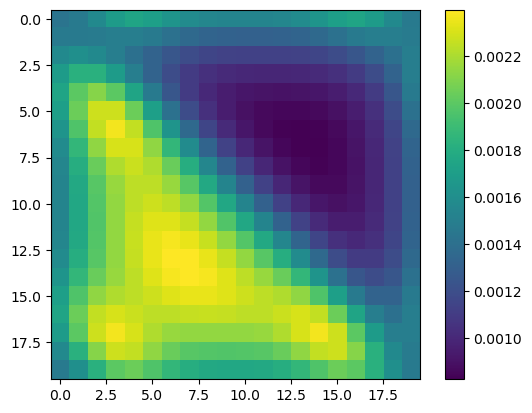

In [82]:
plt.imshow(omega_i_k_comp.real)
plt.colorbar()

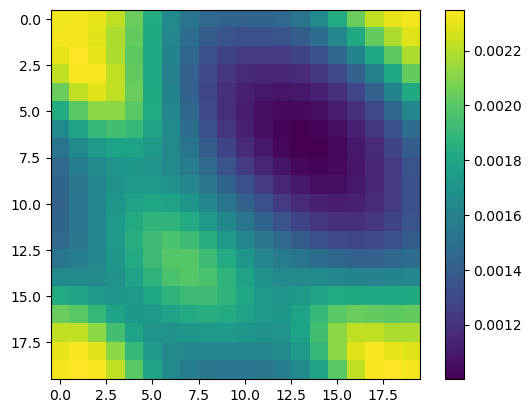

In [75]:
plt.imshow(omega_I_til_k.real)
plt.colorbar()

/Users/treycole/miniforge3/envs/rutgers/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/treycole/miniforge3/envs/rutgers/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


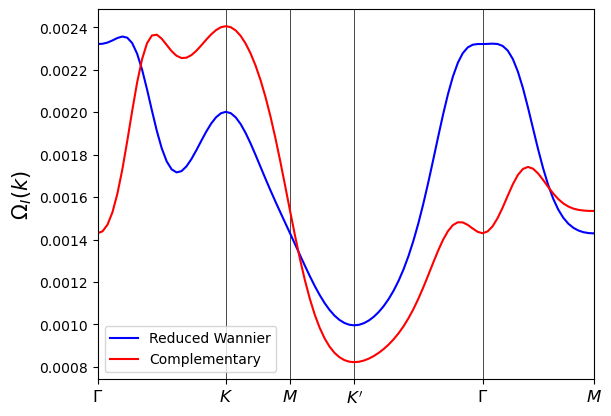

In [66]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.plot(k_dist, omega_I_til_k_interp, c='b', label='Reduced Wannier')
ax.plot(k_dist, omega_I_k_comp_interp, c='r', label='Complementary')
ax.set_ylabel(r'$\Omega_I(k)$', size=15)
ax.legend()

In [70]:
WF_comp = Wannier(model, [20, 20])
WF_comp.set_tilde_states(u_comp, cell_periodic=True)

WF_comp.max_loc(eps=1e-3, iter_num=20000, tol=1e-30, grad_min=1e-12, verbose=True)

0 Omega_til = 5.6655785423417395, Grad mag: 4.547473508864641e-13
1 Omega_til = 4.900229445758416, Grad mag: 4.547473508864641e-13
2 Omega_til = 4.400766407234814, Grad mag: 0.0
3 Omega_til = 4.0603372671571, Grad mag: 0.0
4 Omega_til = 3.8178230912963556, Grad mag: 1.1368683772161603e-13
5 Omega_til = 3.6544642729228896, Grad mag: 2.2737367544323206e-13
6 Omega_til = 3.537257089099762, Grad mag: 3.410605131648481e-13
7 Omega_til = 3.449159135823846, Grad mag: 1.1368683772161603e-13
8 Omega_til = 3.3732568078406087, Grad mag: 2.2737367544323206e-13
9 Omega_til = 3.3134097798628575, Grad mag: 1.1368683772161603e-13
10 Omega_til = 3.2598738375710274, Grad mag: 2.2737367544323206e-13
11 Omega_til = 3.216301018765931, Grad mag: 1.1368683772161603e-13
12 Omega_til = 3.1763242985761155, Grad mag: 2.2737367544323206e-13
13 Omega_til = 3.1430729049522244, Grad mag: 1.1368683772161603e-13
14 Omega_til = 3.112022270907433, Grad mag: 0.0
15 Omega_til = 3.082925422453548, Grad mag: 1.1368683772161

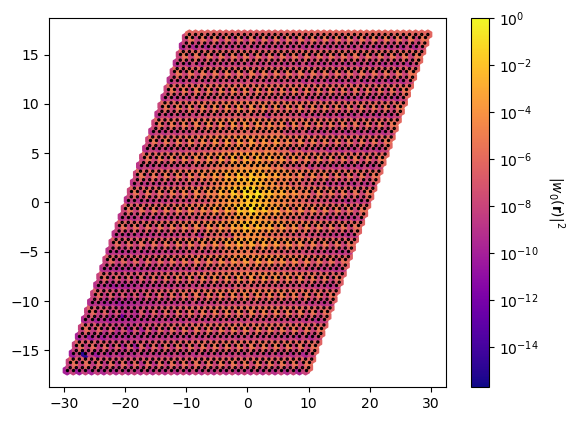

In [72]:
WF_comp.plot_density(0)

Quantum geometric tensor along high-symmetry path

In [62]:
QGT = model.quantum_geom_tens(k_vec) # shape: (k, band, dim r, dim r)
Omega_path = -2 * QGT.imag
g_path = QGT.real

omega_I = np.trace(g_path, axis1=2, axis2=3)
Omega_path.shape

(101, 8, 2, 2)

In [63]:
QGT_rot = interp_unk_til.conj() @ QGT @ np.transpose(interp_unk_til,  axes=(0,2,1))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 8)

In [51]:
model.Chern_num()

array([ 0.01805182,  0.12015709,  0.12327735,  0.73851374, -0.73851374,
       -0.12327735, -0.12015709, -0.01805182])

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

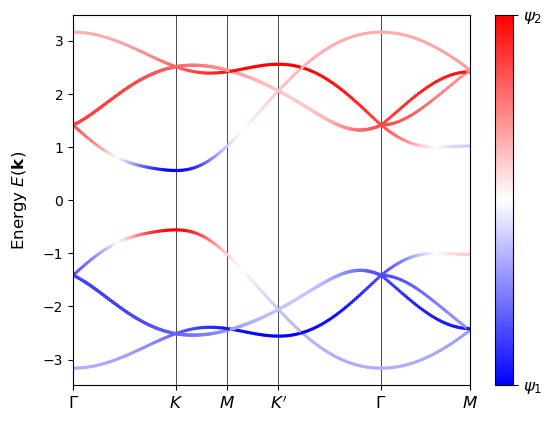

In [47]:
model.plot_bands(
    k_path, k_label=k_label, nk=201, scat_size=2, red_lat_idx=high_E_sites
    )

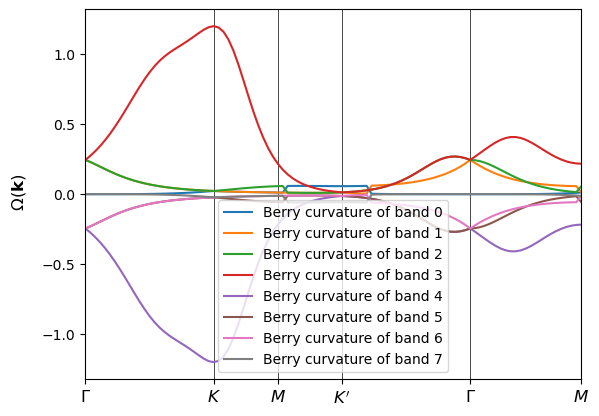

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $\Omega(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

for n in range(n_orb):
    ax.plot(k_dist, Omega_path[:, n, 0, 1], label=f'Berry curvature of band {n}' )

# idx = 4
# ax.plot(k_dist, Omega_path[:, idx, 0, 1], label=f'Berry curvature of band {idx}' )

ax.legend()

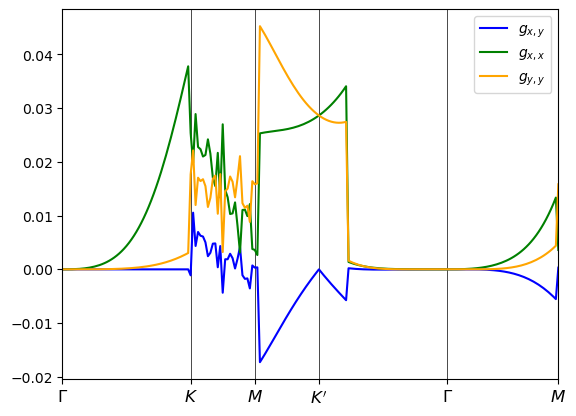

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.yaxis.labelpad = 10

for n in range(1):
    plt.plot(k_dist, g_path[:, n, 0, 1], c='b', label=r'$g_{x,y}$' )
    plt.plot(k_dist, g_path[:, n, 0, 0], c='g', label=r'$g_{x,x}$')
    plt.plot(k_dist, g_path[:, n, 1, 1], c='orange', label=r'$g_{y,y}$' )

ax.legend()

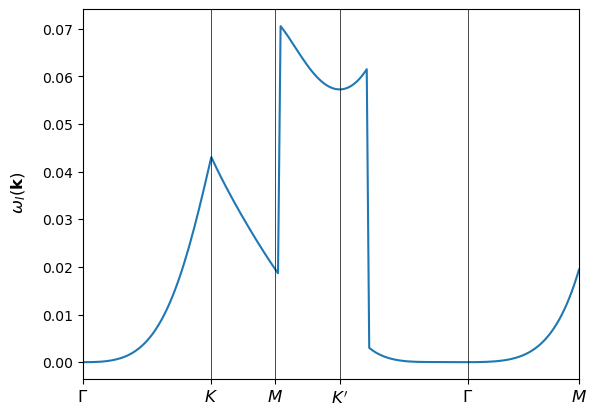

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 201, report=False)

ax.plot(k_dist, omega_I[:, 0])

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r" $\omega_I(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

In [16]:
nkx, nky = 20, 20
k_mesh = K_mesh(model, nkx, nky)
full_mesh = k_mesh.gen_k_mesh(endpoint=False)
full_mesh_mat = k_mesh.gen_k_mesh(flat=False, endpoint=False)
recip_lat_vecs = model.get_recip_lat_vecs()
mesh_Cart = full_mesh_mat @ recip_lat_vecs

KX = mesh_Cart[:, :, 0]
KY = mesh_Cart[:, :, 1]

QGT = model.quantum_geom_tens(full_mesh)
Omega = -2 * QGT.imag 
g = QGT.real

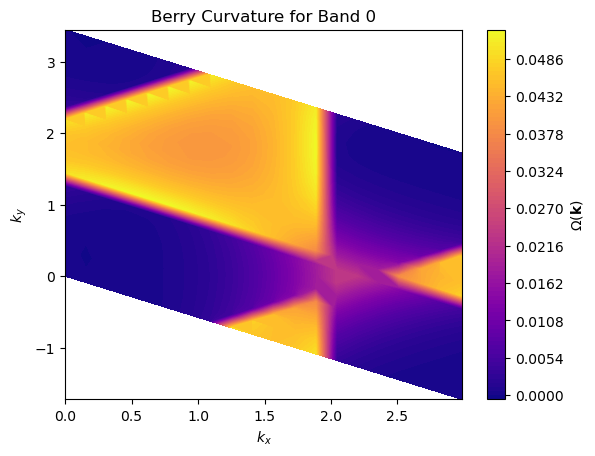

In [17]:
# Reshape Omega for plotting
band_idx = 0
Omega_band = Omega[:, band_idx, 0, 1].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.contourf(KX, KY, Omega_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Berry Curvature for Band {band_idx}')
# plt.gca().set_aspect('equal')
plt.show()

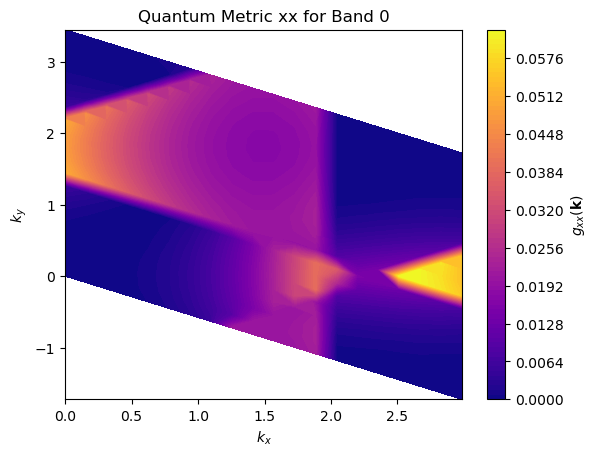

In [18]:
# Reshape Omega for plotting
band_idx = 0
gxx_band = g[:, band_idx, 0, 0].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.contourf(KX, KY, gxx_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$g_{xx}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric xx for Band {band_idx}')
plt.show()

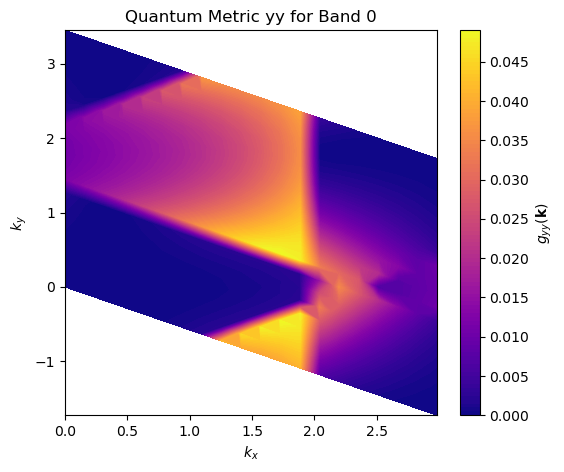

In [19]:
# Reshape Omega for plotting
band_idx = 0
gyy_band = g[:, band_idx, 1, 1].reshape(nkx, nky)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, gyy_band, levels=100, cmap='plasma')
plt.colorbar(label=r'$g_{yy}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric yy for Band {band_idx}')
plt.show()

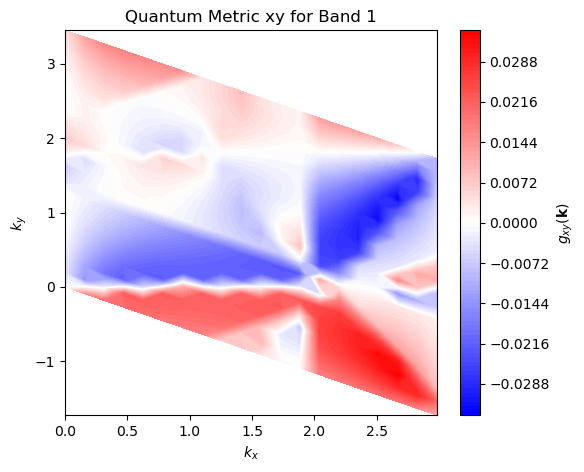

In [20]:
# Reshape Omega for plotting
band_idx = 1
gxy_band = g[:, band_idx, 0, 1].reshape(nkx, nky)

# Generate k-grid for plotting
kx_vals = np.linspace(0, 1, nkx)
ky_vals = np.linspace(0, 1, nky)
# KX, KY = np.meshgrid(kx_vals, ky_vals)

# Plot Berry curvature for band 0
plt.figure(figsize=(6, 5))
plt.contourf(KX, KY, gxy_band, levels=100, cmap='bwr')
plt.colorbar(label=r'$g_{xy}(\mathbf{k})$')
plt.xlabel('$k_x$')
plt.ylabel('$k_y$')
plt.title(f'Quantum Metric xy for Band {band_idx}')
plt.show()